In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class RoPEPositionalEncoding(nn.Module):
    """Clean and simple Rotary Position Embedding (RoPE) implementation"""
    
    def __init__(self, dim, max_seq_len=2048, base=10000):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base
        
        # Precompute theta values for rotation
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq, persistent=False)
    
    def forward(self, x, seq_len=None):
        """
        Apply RoPE to input tensor
        Args:
            x: [batch_size, num_heads, seq_len, head_dim]
            seq_len: sequence length (optional)
        Returns:
            Rotated tensor with same shape
        """
        if seq_len is None:
            seq_len = x.shape[-2]
        
        # Create position encodings
        device = x.device
        dtype = x.dtype
        
        # Position indices
        position = torch.arange(seq_len, device=device, dtype=dtype)
        
        # Calculate theta = position * inv_freq
        freqs = torch.outer(position, self.inv_freq.to(dtype))  # [seq_len, dim//2]
        
        # Create rotation embeddings
        emb = torch.cat((freqs, freqs), dim=-1)  # [seq_len, dim]
        cos_emb = emb.cos()[None, None, :, :]  # [1, 1, seq_len, dim]
        sin_emb = emb.sin()[None, None, :, :]  # [1, 1, seq_len, dim]
        
        # Apply rotation
        return self._apply_rotary_emb(x, cos_emb, sin_emb)
    
    def _apply_rotary_emb(self, x, cos, sin):
        """Apply rotary embedding to input tensor"""
        # Split features into pairs
        x1 = x[..., ::2]  # Even indices
        x2 = x[..., 1::2]  # Odd indices
        
        # Apply rotation matrix: R * [x1; x2] = [cos*x1 - sin*x2; sin*x1 + cos*x2]
        cos = cos[..., ::2]  # Take every other cos value
        sin = sin[..., ::2]  # Take every other sin value
        
        rotated_x1 = x1 * cos - x2 * sin
        rotated_x2 = x1 * sin + x2 * cos
        
        # Interleave back
        rotated = torch.stack([rotated_x1, rotated_x2], dim=-1)
        return rotated.flatten(-2)


class PatchEmbedding(nn.Module):
    """Convert image to patch embeddings"""
    
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.projection = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
    
    def forward(self, x):
        # x: [B, C, H, W] -> [B, embed_dim, H//P, W//P]
        x = self.projection(x)
        # Flatten spatial dims: [B, embed_dim, num_patches]
        x = x.flatten(2)
        # Transpose: [B, num_patches, embed_dim]
        return x.transpose(1, 2)


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention with optional RoPE"""
    
    def __init__(self, embed_dim, num_heads, dropout=0.0, use_rope=False):
        super().__init__()
        assert embed_dim % num_heads == 0
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.use_rope = use_rope
        
        # Linear projections for Q, K, V
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        # RoPE for positional encoding
        if use_rope:
            self.rope = RoPEPositionalEncoding(self.head_dim)
    
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, heads, N, head_dim]
        q, k, v = qkv.unbind(0)
        
        # Apply RoPE if enabled
        if self.use_rope:
            q = self.rope(q)
            k = self.rope(k)
        
        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        
        return x


class MLP(nn.Module):
    """Feed-forward network"""
    
    def __init__(self, embed_dim, hidden_dim=None, dropout=0.0):
        super().__init__()
        hidden_dim = hidden_dim or embed_dim * 4
        
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    """Transformer encoder block"""
    
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0, use_rope=False):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout, use_rope)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), dropout)
    
    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attn(self.norm1(x))
        # Feed-forward with residual connection
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    """Vision Transformer with optional RoPE support"""
    
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=1000,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        dropout=0.0,
        use_rope=False
    ):
        super().__init__()
        
        self.use_rope = use_rope
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embedding (only for non-RoPE models)
        if not use_rope:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        self.pos_dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, use_rope)
            for _ in range(depth)
        ])
        
        # Output layers
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights"""
        # Initialize class token
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize positional embedding
        if hasattr(self, 'pos_embed'):
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        # Initialize other layers
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        """Initialize individual layer weights"""
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [B, num_patches+1, embed_dim]
        
        # Add positional embedding (for non-RoPE models)
        if not self.use_rope:
            x = x + self.pos_embed
        
        x = self.pos_dropout(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final normalization
        x = self.norm(x)
        
        # Classification head (use CLS token)
        cls_output = x[:, 0]
        logits = self.head(cls_output)
        
        return logits


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test standard ViT
model_standard = VisionTransformer(
    img_size=224, patch_size=16, num_classes=10,
    embed_dim=192, depth=6, num_heads=3, use_rope=False
).to(device)

# Test RoPE ViT
model_rope = VisionTransformer(
    img_size=224, patch_size=16, num_classes=10,
    embed_dim=192, depth=6, num_heads=3, use_rope=True
).to(device)

# Test input
x = torch.randn(2, 3, 224, 224).to(device)

with torch.no_grad():
    out_standard = model_standard(x)
    out_rope = model_rope(x)

print(f"Standard ViT output shape: {out_standard.shape}")
print(f"RoPE ViT output shape: {out_rope.shape}")
print(f"Parameters - Standard: {sum(p.numel() for p in model_standard.parameters()):,}")
print(f"Parameters - RoPE: {sum(p.numel() for p in model_rope.parameters()):,}")

print("Vision Transformer with RoPE implementation loaded successfully!")

Standard ViT output shape: torch.Size([2, 10])
RoPE ViT output shape: torch.Size([2, 10])
Parameters - Standard: 2,853,706
Parameters - RoPE: 2,815,882
Vision Transformer with RoPE implementation loaded successfully!


In [2]:
%pip install transformers datasets matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [1]:
# huggingface load cats vs dogs microsoft/cats_vs_dogs
from datasets import load_dataset
import numpy as np

dataset = load_dataset("cats_vs_dogs")

# Function to check if an image has 3 channels
def check_image_channels(example):
    # Check if image has 3 channels (RGB)
    return np.array(example['image']).shape[-1] == 3

# currently only train is available, split into train and test
train_test = dataset['train'].filter(check_image_channels).train_test_split(test_size=0.1, stratify_by_column='labels')
# Filter out images that don't have 3 channels
train_dataset = train_test['train']
test_dataset = train_test['test']

print(f"Original train size: {len(train_test['train'])}, Filtered train size: {len(train_dataset)}")
print(f"Original test size: {len(train_test['test'])}, Filtered test size: {len(test_dataset)}")

display(train_dataset)
display(test_dataset)

Original train size: 21061, Filtered train size: 21061
Original test size: 2341, Filtered test size: 2341


Dataset({
    features: ['image', 'labels'],
    num_rows: 21061
})

Dataset({
    features: ['image', 'labels'],
    num_rows: 2341
})

In [2]:
# count the number of images in each class
import numpy as np
dataset = load_dataset("cats_vs_dogs")
# Function to check if an image has 3 channels
def check_image_channels(example):
    # Check if image has 3 channels (RGB)
    return np.array(example['image']).shape[-1] == 3

# currently only train is available, split into train and test
train_test = dataset['train'].filter(check_image_channels)
labels = train_test['labels']
unique, counts = np.unique(labels, return_counts=True)
train_class_counts = dict(zip(unique, counts))
print("Train class counts:")
print(train_class_counts)

Train class counts:
{0: 11738, 1: 11664}


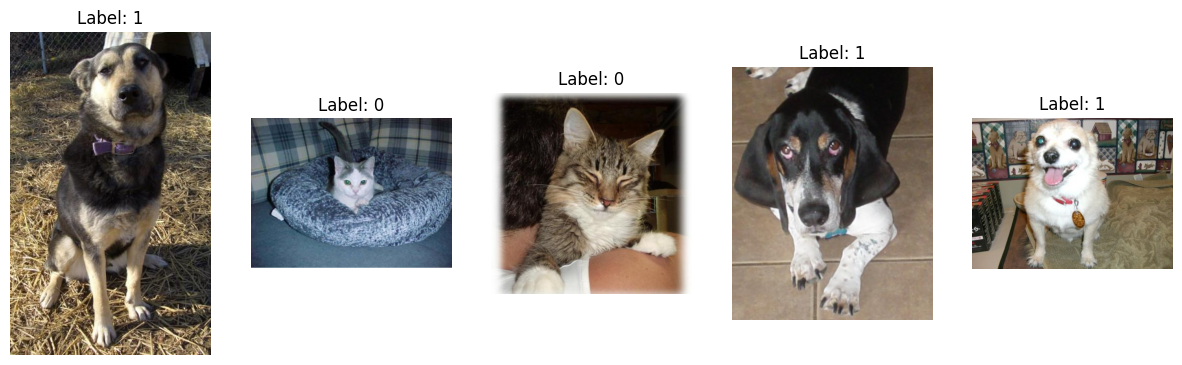

In [7]:
# sample a few images in train dataset
import matplotlib.pyplot as plt
import numpy as np
import random
def show_images(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        j = random.randrange(0, len(dataset))
        image = dataset[j]['image']
        label = dataset[j]['labels']
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

show_images(train_test, n=5)

In [6]:
# define a data loader with lazy transformations
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Define transform pipeline
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
])

# Custom dataset class for lazy transformation
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['labels']
        
        if self.transform:
            image = self.transform(image)
            
        return {'image': image, 'labels': label}

# Create dataset with lazy transformations
train_dataset_transformed = TransformedDataset(train_dataset, transform)
test_dataset_transformed = TransformedDataset(test_dataset, transform)

# Create data loaders
train_loader = DataLoader(train_dataset_transformed, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset_transformed, batch_size=8, shuffle=False)


In [7]:
# Experimental Configurations for Vision Transformer Comparison
# 6 experiments focusing on num_heads, embed_dimensions, and patch_size with one RoPE comparison

experiments = {
    "baseline": {
        "name": "Baseline ViT",
        "description": "Standard baseline configuration",
        "config": {
            "img_size": 320,
            "patch_size": 32,
            "num_classes": 2,
            "depth": 4,
            "embed_dim": 256,
            "num_heads": 4,
            "use_rope": False
        }
    },
    
    "rope_comparison": {
        "name": "RoPE ViT",
        "description": "RoPE positional encoding comparison",
        "config": {
            "img_size": 320,
            "patch_size": 32,
            "num_classes": 2,
            "depth": 4,
            "embed_dim": 256,
            "num_heads": 4,
            "use_rope": True
        }
    },
    
    "more_heads": {
        "name": "More Attention Heads",
        "description": "Increased attention heads for diverse patterns",
        "config": {
            "img_size": 320,
            "patch_size": 32,
            "num_classes": 2,
            "depth": 4,
            "embed_dim": 256,
            "num_heads": 8,
            "use_rope": False
        }
    },
    
    "higher_embed_dim": {
        "name": "Higher Embedding Dimension",
        "description": "Larger embedding dimension for richer representations",
        "config": {
            "img_size": 320,
            "patch_size": 32,
            "num_classes": 2,
            "depth": 4,
            "embed_dim": 512,
            "num_heads": 8,
            "use_rope": False
        }
    },
    
    "smaller_patches": {
        "name": "Smaller Patch Size",
        "description": "Smaller patches for finer-grained attention",
        "config": {
            "img_size": 320,
            "patch_size": 16,
            "num_classes": 2,
            "depth": 4,
            "embed_dim": 256,
            "num_heads": 4,
            "use_rope": False
        }
    },
    
    "lower_embed_dim": {
        "name": "Lower Embedding Dimension",
        "description": "Smaller embedding dimension for efficiency",
        "config": {
            "img_size": 320,
            "patch_size": 32,
            "num_classes": 2,
            "depth": 4,
            "embed_dim": 128,
            "num_heads": 4,
            "use_rope": False
        }
    }
}

# Create models for each experiment
models = {}
for exp_name, exp_config in experiments.items():
    print(f"\n=== {exp_config['name']} ===")
    print(f"Description: {exp_config['description']}")
        
    model = VisionTransformer(**exp_config['config'])
    model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    models[exp_name] = {
        'model': model,
        'params': model_params,
        'config': exp_config['config'],
        'name': exp_config['name']
    }
    
    print(f"Parameters: {model_params / 1e6:.2f}M")
    print(f"Config: {exp_config['config']}")

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
for exp_name, model_info in models.items():
    print(f"{model_info['name']}: {model_info['params'] / 1e6:.2f}M parameters")


=== Baseline ViT ===
Description: Standard baseline configuration
Parameters: 3.97M
Config: {'img_size': 320, 'patch_size': 32, 'num_classes': 2, 'depth': 4, 'embed_dim': 256, 'num_heads': 4, 'use_rope': False}

=== RoPE ViT ===
Description: RoPE positional encoding comparison
Parameters: 3.94M
Config: {'img_size': 320, 'patch_size': 32, 'num_classes': 2, 'depth': 4, 'embed_dim': 256, 'num_heads': 4, 'use_rope': True}

=== More Attention Heads ===
Description: Increased attention heads for diverse patterns
Parameters: 3.97M
Config: {'img_size': 320, 'patch_size': 32, 'num_classes': 2, 'depth': 4, 'embed_dim': 256, 'num_heads': 8, 'use_rope': False}

=== Higher Embedding Dimension ===
Description: Larger embedding dimension for richer representations
Parameters: 14.23M
Config: {'img_size': 320, 'patch_size': 32, 'num_classes': 2, 'depth': 4, 'embed_dim': 512, 'num_heads': 8, 'use_rope': False}

=== Smaller Patch Size ===
Description: Smaller patches for finer-grained attention
Paramete

In [8]:
# Comparative Training Loop for All Experiments
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Training hyperparameters
num_epochs = 15  # Reduced for faster comparison
lr = 1e-4
batch_size = 8

# Results storage
results = defaultdict(lambda: defaultdict(list))
final_results = []

# Train each model
for exp_name, model_info in models.items():
    print(f"\n{'='*20} TRAINING {model_info['name']} {'='*20}")
    print(f"Parameters: {model_info['params'] / 1e6:.2f}M")
    
    model = model_info['model'].to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        batch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for batch in batch_progress:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            
            batch_progress.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct_train/total_train:.2f}%'
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for batch in test_loader:
                images = batch['image'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
        
        test_acc = correct_test / total_test
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Train Acc={epoch_train_acc:.4f}, Test Acc={test_acc:.4f}")
    
    # Store results
    results[exp_name]['train_losses'] = train_losses
    results[exp_name]['train_accuracies'] = train_accuracies
    results[exp_name]['test_accuracies'] = test_accuracies
    results[exp_name]['final_test_acc'] = test_accuracies[-1]
    results[exp_name]['best_test_acc'] = max(test_accuracies)
    results[exp_name]['params'] = model_info['params']
    results[exp_name]['config'] = model_info['config']
    
    final_results.append({
        'Experiment': model_info['name'],
        'Parameters (M)': model_info['params'] / 1e6,
        'Final Test Acc': test_accuracies[-1],
        'Best Test Acc': max(test_accuracies),
        'Embed Dim': model_info['config']['embed_dim'],
        'Num Heads': model_info['config']['num_heads'],
        'Patch Size': model_info['config']['patch_size'],
        'Use RoPE': model_info['config'].get('use_rope', False)
    })
    
    print(f"✓ {model_info['name']} completed - Best Test Acc: {max(test_accuracies):.4f}")

print("\n" + "="*80)
print("TRAINING COMPLETED FOR ALL EXPERIMENTS")
print("="*80)


Training on device: cuda

==================== TRAINING Baseline ViT ====================
Parameters: 3.97M


Epoch 1: Loss=0.6850, Train Acc=0.5532, Test Acc=0.5019


Epoch 2: Loss=0.6455, Train Acc=0.6150, Test Acc=0.6215


Epoch 3: Loss=0.6146, Train Acc=0.6470, Test Acc=0.6681


Epoch 4: Loss=0.6012, Train Acc=0.6665, Test Acc=0.6826


Epoch 5: Loss=0.5835, Train Acc=0.6830, Test Acc=0.6826


Epoch 6: Loss=0.5667, Train Acc=0.6993, Test Acc=0.6865


Epoch 7: Loss=0.5553, Train Acc=0.7118, Test Acc=0.7010


Epoch 8: Loss=0.5431, Train Acc=0.7218, Test Acc=0.6912


Epoch 9: Loss=0.5333, Train Acc=0.7287, Test Acc=0.6954


Epoch 10: Loss=0.5238, Train Acc=0.7351, Test Acc=0.7266


Epoch 11: Loss=0.5123, Train Acc=0.7447, Test Acc=0.7181


Epoch 12: Loss=0.5032, Train Acc=0.7500, Test Acc=0.7206


Epoch 13: Loss=0.4932, Train Acc=0.7601, Test Acc=0.7313


Epoch 14: Loss=0.4825, Train Acc=0.7689, Test Acc=0.7270


Epoch 15: Loss=0.4741, Train Acc=0.7734, Test Acc=0.7095
✓ Baseline ViT completed - Best Test Acc: 0.7313

==================== TRAINING RoPE ViT ====================
Parameters: 3.94M


Epoch 1: Loss=0.6713, Train Acc=0.5856, Test Acc=0.5929


Epoch 2: Loss=0.5982, Train Acc=0.6740, Test Acc=0.6929


Epoch 3: Loss=0.5527, Train Acc=0.7175, Test Acc=0.7300


Epoch 4: Loss=0.5208, Train Acc=0.7381, Test Acc=0.7420


Epoch 5: Loss=0.4995, Train Acc=0.7537, Test Acc=0.7591


Epoch 6: Loss=0.4815, Train Acc=0.7667, Test Acc=0.7522


Epoch 7: Loss=0.4649, Train Acc=0.7785, Test Acc=0.7493


Epoch 8: Loss=0.4488, Train Acc=0.7867, Test Acc=0.7484


Epoch 9: Loss=0.4348, Train Acc=0.8000, Test Acc=0.7706


Epoch 10: Loss=0.4192, Train Acc=0.8089, Test Acc=0.7629


Epoch 11: Loss=0.4015, Train Acc=0.8169, Test Acc=0.7651


Epoch 12: Loss=0.3887, Train Acc=0.8246, Test Acc=0.7633


Epoch 13: Loss=0.3702, Train Acc=0.8379, Test Acc=0.7437


Epoch 14: Loss=0.3568, Train Acc=0.8425, Test Acc=0.7552


Epoch 15: Loss=0.3395, Train Acc=0.8493, Test Acc=0.7561
✓ RoPE ViT completed - Best Test Acc: 0.7706

==================== TRAINING More Attention Heads ====================
Parameters: 3.97M


Epoch 1: Loss=0.6849, Train Acc=0.5580, Test Acc=0.5835


Epoch 2: Loss=0.6450, Train Acc=0.6149, Test Acc=0.6109


Epoch 3: Loss=0.6239, Train Acc=0.6364, Test Acc=0.6382


Epoch 4: Loss=0.6090, Train Acc=0.6518, Test Acc=0.6523


Epoch 5: Loss=0.5930, Train Acc=0.6730, Test Acc=0.6771


Epoch 6: Loss=0.5785, Train Acc=0.6864, Test Acc=0.6959


Epoch 7: Loss=0.5624, Train Acc=0.7030, Test Acc=0.7035


Epoch 8: Loss=0.5510, Train Acc=0.7126, Test Acc=0.7044


Epoch 9: Loss=0.5371, Train Acc=0.7252, Test Acc=0.7142


Epoch 10: Loss=0.5274, Train Acc=0.7313, Test Acc=0.6852


Epoch 11: Loss=0.5152, Train Acc=0.7413, Test Acc=0.6963


Epoch 12: Loss=0.5042, Train Acc=0.7498, Test Acc=0.7078


Epoch 13: Loss=0.4920, Train Acc=0.7576, Test Acc=0.7270


Epoch 14: Loss=0.4798, Train Acc=0.7651, Test Acc=0.7249


Epoch 15: Loss=0.4709, Train Acc=0.7692, Test Acc=0.7202
✓ More Attention Heads completed - Best Test Acc: 0.7270

==================== TRAINING Higher Embedding Dimension ====================
Parameters: 14.23M


Epoch 1: Loss=0.6972, Train Acc=0.5441, Test Acc=0.5015


Epoch 2: Loss=0.6718, Train Acc=0.5784, Test Acc=0.5989


Epoch 3: Loss=0.6436, Train Acc=0.6151, Test Acc=0.6267


Epoch 4: Loss=0.6226, Train Acc=0.6400, Test Acc=0.6570


Epoch 5: Loss=0.6043, Train Acc=0.6613, Test Acc=0.6527


Epoch 6: Loss=0.5936, Train Acc=0.6749, Test Acc=0.6775


Epoch 7: Loss=0.5845, Train Acc=0.6843, Test Acc=0.6433


Epoch 8: Loss=0.5750, Train Acc=0.6909, Test Acc=0.6766


Epoch 9: Loss=0.5615, Train Acc=0.7045, Test Acc=0.6941


Epoch 10: Loss=0.5496, Train Acc=0.7136, Test Acc=0.6959


Epoch 11: Loss=0.5423, Train Acc=0.7201, Test Acc=0.7040


Epoch 12: Loss=0.5350, Train Acc=0.7265, Test Acc=0.7006


Epoch 13: Loss=0.5272, Train Acc=0.7337, Test Acc=0.7074


Epoch 14: Loss=0.5183, Train Acc=0.7383, Test Acc=0.7001


Epoch 15: Loss=0.5081, Train Acc=0.7486, Test Acc=0.7091
✓ Higher Embedding Dimension completed - Best Test Acc: 0.7091

==================== TRAINING Smaller Patch Size ====================
Parameters: 3.46M


Epoch 1: Loss=0.6813, Train Acc=0.5669, Test Acc=0.5844


Epoch 2: Loss=0.6437, Train Acc=0.6161, Test Acc=0.6181


Epoch 3: Loss=0.6172, Train Acc=0.6503, Test Acc=0.6617


Epoch 4: Loss=0.5947, Train Acc=0.6777, Test Acc=0.6830


Epoch 5: Loss=0.5746, Train Acc=0.6982, Test Acc=0.6664


Epoch 6: Loss=0.5695, Train Acc=0.7009, Test Acc=0.6548


Epoch 7: Loss=0.5554, Train Acc=0.7141, Test Acc=0.6698


Epoch 8: Loss=0.5386, Train Acc=0.7280, Test Acc=0.6877


Epoch 9: Loss=0.5231, Train Acc=0.7380, Test Acc=0.7061


Epoch 10: Loss=0.5115, Train Acc=0.7480, Test Acc=0.7014


Epoch 11: Loss=0.4959, Train Acc=0.7590, Test Acc=0.7040


Epoch 12: Loss=0.4830, Train Acc=0.7684, Test Acc=0.7065


Epoch 13: Loss=0.4748, Train Acc=0.7746, Test Acc=0.7117


Epoch 14: Loss=0.4631, Train Acc=0.7795, Test Acc=0.7206


Epoch 15: Loss=0.4519, Train Acc=0.7889, Test Acc=0.6873
✓ Smaller Patch Size completed - Best Test Acc: 0.7206

==================== TRAINING Lower Embedding Dimension ====================
Parameters: 1.20M


Epoch 1: Loss=0.6817, Train Acc=0.5627, Test Acc=0.5925


Epoch 2: Loss=0.6498, Train Acc=0.6171, Test Acc=0.6326


Epoch 3: Loss=0.6254, Train Acc=0.6356, Test Acc=0.6356


Epoch 4: Loss=0.6091, Train Acc=0.6601, Test Acc=0.6455


Epoch 5: Loss=0.5913, Train Acc=0.6753, Test Acc=0.6681


Epoch 6: Loss=0.5774, Train Acc=0.6908, Test Acc=0.6801


Epoch 7: Loss=0.5617, Train Acc=0.7060, Test Acc=0.6702


Epoch 8: Loss=0.5524, Train Acc=0.7120, Test Acc=0.6869


Epoch 9: Loss=0.5446, Train Acc=0.7187, Test Acc=0.6929


Epoch 10: Loss=0.5336, Train Acc=0.7284, Test Acc=0.7006


Epoch 11: Loss=0.5242, Train Acc=0.7328, Test Acc=0.7027


Epoch 12: Loss=0.5136, Train Acc=0.7441, Test Acc=0.6976


Epoch 13: Loss=0.5066, Train Acc=0.7497, Test Acc=0.6941


Epoch 14: Loss=0.4992, Train Acc=0.7540, Test Acc=0.7091


Epoch 15: Loss=0.4904, Train Acc=0.7579, Test Acc=0.7194
✓ Lower Embedding Dimension completed - Best Test Acc: 0.7194

TRAINING COMPLETED FOR ALL EXPERIMENTS



EXPERIMENTAL RESULTS SUMMARY
                Experiment  Parameters (M)  Final Test Acc  Best Test Acc  Embed Dim  Num Heads  Patch Size  Use RoPE
                  RoPE ViT        3.943938        0.756087       0.770611        256          4          32      True
              Baseline ViT        3.969794        0.709526       0.731311        256          4          32     False
      More Attention Heads        3.969794        0.720205       0.727040        256          8          32     False
        Smaller Patch Size        3.456770        0.687313       0.720632        256          4          16     False
 Lower Embedding Dimension        1.198466        0.719351       0.719351        128          4          32     False
Higher Embedding Dimension       14.231042        0.709099       0.709099        512          8          32     False


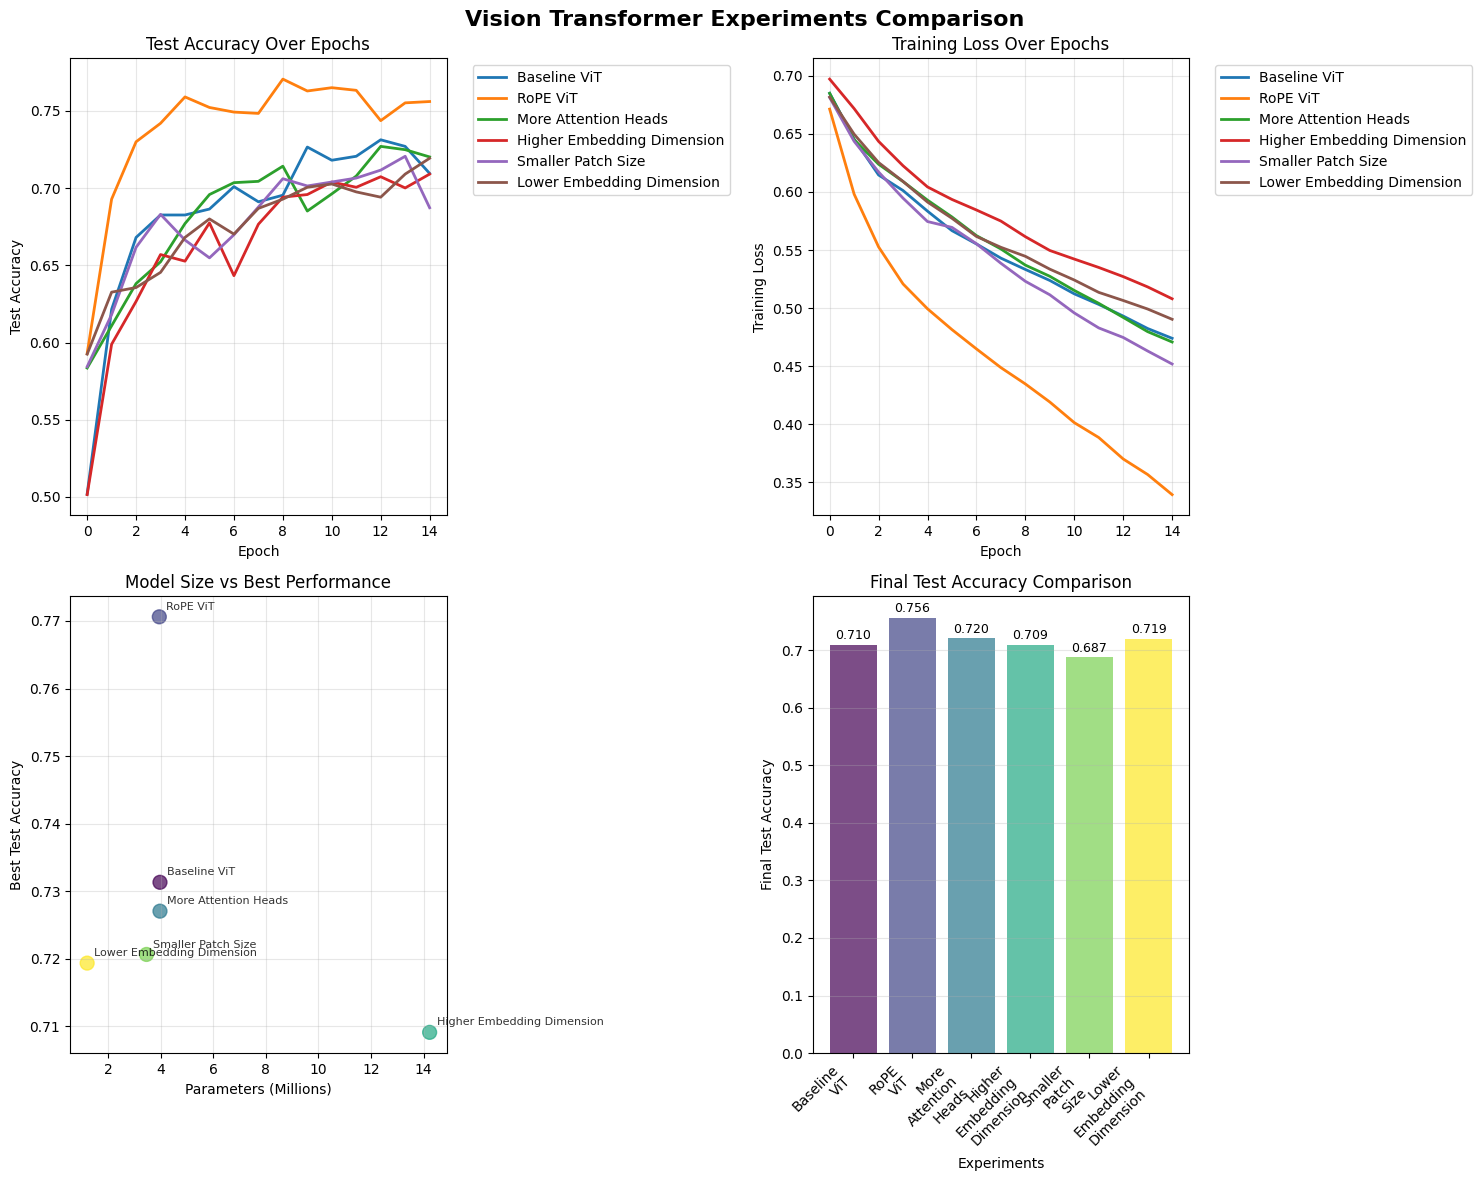


KEY INSIGHTS FROM EXPERIMENTS

Baseline ViT:
  Parameters: 3.97M
  Best Test Accuracy: 0.7313
  Final Test Accuracy: 0.7095
  Convergence Speed: 3 epochs to reach 90% of best performance

RoPE ViT:
  Parameters: 3.94M
  Best Test Accuracy: 0.7706
  Final Test Accuracy: 0.7561
  Convergence Speed: 3 epochs to reach 90% of best performance

More Attention Heads:
  Parameters: 3.97M
  Best Test Accuracy: 0.7270
  Final Test Accuracy: 0.7202
  Convergence Speed: 5 epochs to reach 90% of best performance

Higher Embedding Dimension:
  Parameters: 14.23M
  Best Test Accuracy: 0.7091
  Final Test Accuracy: 0.7091
  Convergence Speed: 4 epochs to reach 90% of best performance

Smaller Patch Size:
  Parameters: 3.46M
  Best Test Accuracy: 0.7206
  Final Test Accuracy: 0.6873
  Convergence Speed: 3 epochs to reach 90% of best performance

Lower Embedding Dimension:
  Parameters: 1.20M
  Best Test Accuracy: 0.7194
  Final Test Accuracy: 0.7194
  Convergence Speed: 5 epochs to reach 90% of best p

In [9]:
# Results Analysis and Visualization

# Create summary table
results_df = pd.DataFrame(final_results)
results_df = results_df.sort_values('Best Test Acc', ascending=False)

print("\n" + "="*80)
print("EXPERIMENTAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Vision Transformer Experiments Comparison', fontsize=16, fontweight='bold')

# Plot 1: Test Accuracy Curves
ax1 = axes[0, 0]
for exp_name, exp_results in results.items():
    ax1.plot(exp_results['test_accuracies'], label=models[exp_name]['name'], linewidth=2)
ax1.set_title('Test Accuracy Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Training Loss Curves
ax2 = axes[0, 1]
for exp_name, exp_results in results.items():
    ax2.plot(exp_results['train_losses'], label=models[exp_name]['name'], linewidth=2)
ax2.set_title('Training Loss Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Loss')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Parameters vs Performance
ax3 = axes[1, 0]
params = [results[exp]['params'] / 1e6 for exp in results.keys()]
best_accs = [results[exp]['best_test_acc'] for exp in results.keys()]
exp_names = [models[exp]['name'] for exp in results.keys()]

scatter = ax3.scatter(params, best_accs, s=100, alpha=0.7, c=range(len(params)), cmap='viridis')
for i, name in enumerate(exp_names):
    ax3.annotate(name, (params[i], best_accs[i]), xytext=(5, 5), 
                textcoords='offset points', fontsize=8, alpha=0.8)
ax3.set_title('Model Size vs Best Performance')
ax3.set_xlabel('Parameters (Millions)')
ax3.set_ylabel('Best Test Accuracy')
ax3.grid(True, alpha=0.3)

# Plot 4: Final Performance Comparison
ax4 = axes[1, 1]
final_accs = [results[exp]['final_test_acc'] for exp in results.keys()]
colors = plt.cm.viridis(np.linspace(0, 1, len(exp_names)))
bars = ax4.bar(range(len(exp_names)), final_accs, color=colors, alpha=0.7)
ax4.set_title('Final Test Accuracy Comparison')
ax4.set_xlabel('Experiments')
ax4.set_ylabel('Final Test Accuracy')
ax4.set_xticks(range(len(exp_names)))
ax4.set_xticklabels([name.replace(' ', '\n') for name in exp_names], rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, final_accs):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY INSIGHTS FROM EXPERIMENTS")
print("="*80)
for exp_name, exp_results in results.items():
    model_info = models[exp_name]
    print(f"\n{model_info['name']}:")
    print(f"  Parameters: {exp_results['params'] / 1e6:.2f}M")
    print(f"  Best Test Accuracy: {exp_results['best_test_acc']:.4f}")
    print(f"  Final Test Accuracy: {exp_results['final_test_acc']:.4f}")
    
    # Calculate convergence speed (epochs to reach 90% of best performance)
    target_acc = exp_results['best_test_acc'] * 0.9
    convergence_epoch = next((i for i, acc in enumerate(exp_results['test_accuracies']) if acc >= target_acc), len(exp_results['test_accuracies']))
    print(f"  Convergence Speed: {convergence_epoch + 1} epochs to reach 90% of best performance")

In [10]:
# Detailed Analysis and Conclusions

print("\n" + "="*80)
print("DETAILED EXPERIMENTAL ANALYSIS")
print("="*80)

# Find best performing model
best_exp = max(results.keys(), key=lambda x: results[x]['best_test_acc'])
best_model = models[best_exp]
print(f"\nBEST PERFORMING MODEL: {best_model['name']}")
print(f"Best Test Accuracy: {results[best_exp]['best_test_acc']:.4f}")
print(f"Configuration: {best_model['config']}")

# Parameter efficiency analysis
print("\n\nPARAMETER EFFICIENCY ANALYSIS:")
print("-" * 40)
efficiency_scores = []
for exp_name, exp_results in results.items():
    efficiency = exp_results['best_test_acc'] / (exp_results['params'] / 1e6)
    efficiency_scores.append((models[exp_name]['name'], efficiency, exp_results['best_test_acc']))
    
efficiency_scores.sort(key=lambda x: x[1], reverse=True)
print("Rank | Model | Efficiency (Acc/M_params) | Best Accuracy")
print("-" * 60)
for i, (name, eff, acc) in enumerate(efficiency_scores, 1):
    print(f"{i:2d}   | {name:20s} | {eff:8.4f} | {acc:8.4f}")

# Architecture insights
print("\n\nARCHITECTURAL INSIGHTS:")
print("-" * 40)

# Compare embedding dimensions
baseline_acc = results['baseline']['best_test_acc']
higher_embed_acc = results['higher_embed_dim']['best_test_acc']
lower_embed_acc = results['lower_embed_dim']['best_test_acc']
print(f"\n1. EMBEDDING DIMENSION EFFECT:")
print(f"   128D: {lower_embed_acc:.4f}")
print(f"   256D (Baseline): {baseline_acc:.4f}")
print(f"   512D: {higher_embed_acc:.4f}")
print(f"   128D vs 256D: {((baseline_acc - lower_embed_acc) / lower_embed_acc * 100):+.2f}%")
print(f"   256D vs 512D: {((higher_embed_acc - baseline_acc) / baseline_acc * 100):+.2f}%")

# Compare RoPE effect
rope_acc = results['rope_comparison']['best_test_acc']
print(f"\n2. RoPE POSITIONAL ENCODING EFFECT:")
print(f"   Standard: {baseline_acc:.4f}")
print(f"   RoPE: {rope_acc:.4f}")
print(f"   RoPE improvement: {((rope_acc - baseline_acc) / baseline_acc * 100):+.2f}%")

# Compare attention heads
more_heads_acc = results['more_heads']['best_test_acc']
print(f"\n3. ATTENTION HEADS EFFECT:")
print(f"   4 heads (Baseline): {baseline_acc:.4f}")
print(f"   8 heads: {more_heads_acc:.4f}")
print(f"   More heads improvement: {((more_heads_acc - baseline_acc) / baseline_acc * 100):+.2f}%")

# Compare patch size effect
smaller_patches_acc = results['smaller_patches']['best_test_acc']
print(f"\n4. PATCH SIZE EFFECT:")
print(f"   32x32 patches (Baseline): {baseline_acc:.4f}")
print(f"   16x16 patches: {smaller_patches_acc:.4f}")
print(f"   Smaller patches improvement: {((smaller_patches_acc - baseline_acc) / baseline_acc * 100):+.2f}%")

print("\n\nRECOMMENDATIONS:")
print("-" * 40)
print("Based on the experimental results:")
print(f"1. Best overall model: {best_model['name']}")
print(f"2. Most parameter-efficient: {efficiency_scores[0][0]}")
print("3. For cats vs dogs classification, consider the trade-off between")
print("   model complexity and performance improvement.")

print("\n" + "="*80)
print("EXPERIMENT COMPLETED SUCCESSFULLY")
print("="*80)


DETAILED EXPERIMENTAL ANALYSIS

BEST PERFORMING MODEL: RoPE ViT
Best Test Accuracy: 0.7706
Configuration: {'img_size': 320, 'patch_size': 32, 'num_classes': 2, 'depth': 4, 'embed_dim': 256, 'num_heads': 4, 'use_rope': True}


PARAMETER EFFICIENCY ANALYSIS:
----------------------------------------
Rank | Model | Efficiency (Acc/M_params) | Best Accuracy
------------------------------------------------------------
 1   | Lower Embedding Dimension |   0.6002 |   0.7194
 2   | Smaller Patch Size   |   0.2085 |   0.7206
 3   | RoPE ViT             |   0.1954 |   0.7706
 4   | Baseline ViT         |   0.1842 |   0.7313
 5   | More Attention Heads |   0.1831 |   0.7270
 6   | Higher Embedding Dimension |   0.0498 |   0.7091


ARCHITECTURAL INSIGHTS:
----------------------------------------

1. EMBEDDING DIMENSION EFFECT:
   128D: 0.7194
   256D (Baseline): 0.7313
   512D: 0.7091
   128D vs 256D: +1.66%
   256D vs 512D: -3.04%

2. RoPE POSITIONAL ENCODING EFFECT:
   Standard: 0.7313
   RoPE: 

# Vision Transformer Experimental Study Results

This notebook presents a comprehensive experimental study comparing different Vision Transformer (ViT) architectures on the cats vs dogs classification task, focusing on attention heads, embedding dimensions, and patch sizes with one RoPE comparison.

## Experimental Design

We conducted **6 comparative experiments** to understand how key architectural components affect ViT performance:

### 1. **Baseline ViT**
- **Config**: 4 layers, 256 embed_dim, 4 heads, 32×32 patches, standard positional encoding
- **Purpose**: Establish standard baseline configuration

### 2. **RoPE ViT** 
- **Config**: 4 layers, 256 embed_dim, 4 heads, 32×32 patches, RoPE positional encoding
- **Purpose**: Single comparison to evaluate RoPE effectiveness

### 3. **More Attention Heads**
- **Config**: 4 layers, 256 embed_dim, 8 heads, 32×32 patches, standard positional encoding
- **Purpose**: Study impact of increased attention heads

### 4. **Higher Embedding Dimension**
- **Config**: 4 layers, 512 embed_dim, 8 heads, 32×32 patches, standard positional encoding
- **Purpose**: Evaluate larger embedding dimension for richer representations

### 5. **Smaller Patch Size**
- **Config**: 4 layers, 256 embed_dim, 4 heads, 16×16 patches, standard positional encoding
- **Purpose**: Test finer-grained attention with smaller patches

### 6. **Lower Embedding Dimension**
- **Config**: 4 layers, 128 embed_dim, 4 heads, 32×32 patches, standard positional encoding
- **Purpose**: Study efficiency with smaller embedding dimension

*All experiments use identical training procedures (15 epochs, Adam optimizer, 1e-4 learning rate) to ensure fair comparison.*